In [160]:
!pip install xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [161]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [162]:
train = pd.read_csv('Ashwin-EDA/train_data.csv')

train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,4244605.96
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,3287351.70
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,4219403.66
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,3.0,0,4,0,0,0,0,0,0,3937158.64
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,5877728.96


In [96]:
#over half the data is in urban centers
counts = train['City'].value_counts() 
percent = ((train['City'].value_counts()/train['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
İstanbul,34004,34.1%
Ankara,8700,8.7%
İzmir,6454,6.5%
Antalya,5900,5.9%
Kocaeli,4355,4.4%
Mersin,2731,2.7%
Adana,2510,2.5%
Balıkesir,2457,2.5%
Bursa,2436,2.4%
Muğla,1820,1.8%


In [97]:
from pandas.plotting import scatter_matrix



In [104]:
corr = train[train.columns[train.columns!='Id'] ].corr()


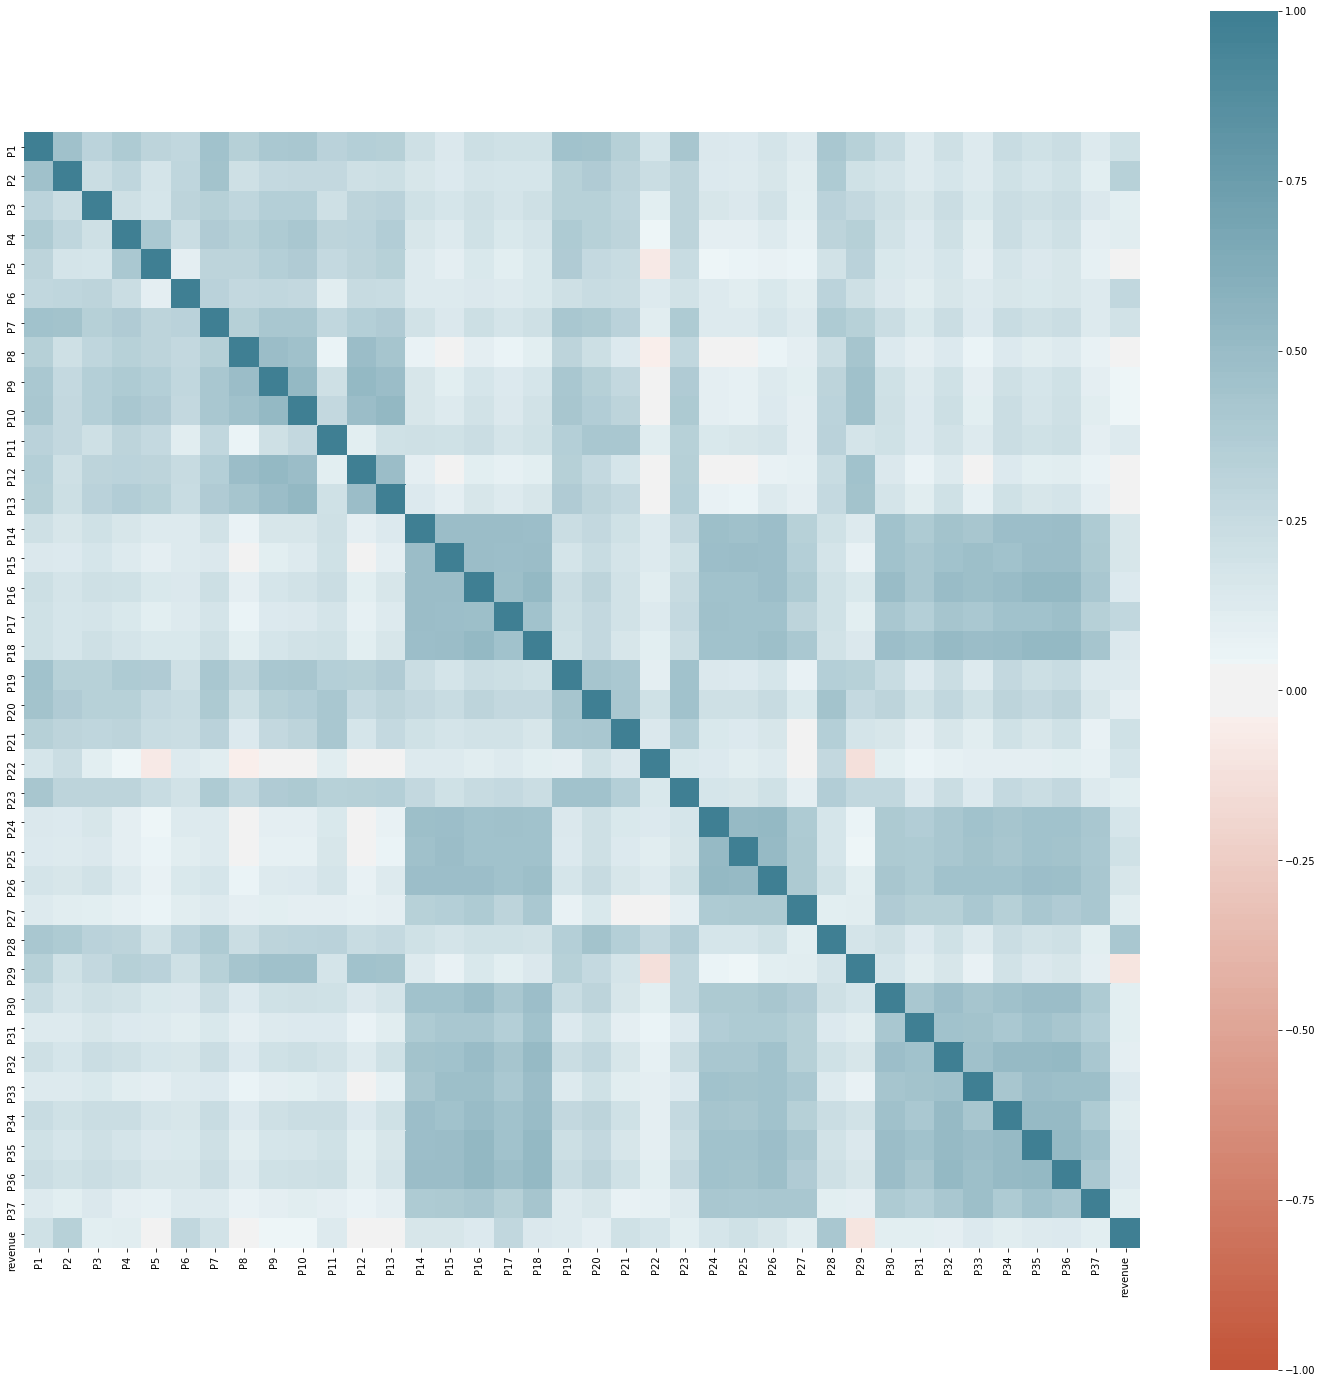

In [116]:
fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [120]:
corr

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
P1,1.000000,0.464240,0.312545,0.377201,0.298485,0.285416,0.457133,0.342021,0.400333,0.412807,...,0.332158,0.246121,0.121939,0.218401,0.130064,0.245281,0.209496,0.233337,0.130989,0.202653
P2,0.464240,1.000000,0.239375,0.294592,0.186558,0.289811,0.438164,0.218077,0.264860,0.280793,...,0.205794,0.186967,0.120284,0.178670,0.125422,0.203386,0.174212,0.197468,0.103421,0.334703
P3,0.312545,0.239375,1.000000,0.216735,0.173253,0.311330,0.342041,0.289299,0.352717,0.357763,...,0.276669,0.215594,0.160491,0.234879,0.155929,0.233055,0.214417,0.228993,0.146693,0.106530
P4,0.377201,0.294592,0.216735,1.000000,0.404814,0.238061,0.368732,0.331159,0.386342,0.413588,...,0.337469,0.192217,0.137195,0.211777,0.110977,0.234119,0.184420,0.213245,0.099481,0.114843
P5,0.298485,0.186558,0.173253,0.404814,1.000000,0.099148,0.296984,0.301617,0.353733,0.374149,...,0.323224,0.150880,0.123280,0.172756,0.088138,0.184938,0.144438,0.171334,0.078644,0.037899
P6,0.285416,0.289811,0.311330,0.238061,0.099148,1.000000,0.326109,0.272577,0.288460,0.279942,...,0.217905,0.141978,0.109731,0.162901,0.125675,0.169463,0.151881,0.164695,0.130388,0.287981
P7,0.457133,0.438164,0.342041,0.368732,0.296984,0.326109,1.000000,0.346285,0.410635,0.414167,...,0.328507,0.230309,0.153537,0.230133,0.137420,0.249997,0.217339,0.235576,0.129740,0.189324
P8,0.342021,0.218077,0.289299,0.331159,0.301617,0.272577,0.346285,1.000000,0.484592,0.462471,...,0.432540,0.140091,0.090964,0.137047,0.050360,0.137850,0.116491,0.118025,0.071076,0.014679
P9,0.400333,0.264860,0.352717,0.386342,0.353733,0.288460,0.410635,0.484592,1.000000,0.529341,...,0.463839,0.207328,0.128152,0.202160,0.091969,0.214640,0.179556,0.195999,0.101223,0.045616
P10,0.412807,0.280793,0.357763,0.413588,0.374149,0.279942,0.414167,0.462471,0.529341,1.000000,...,0.466476,0.211457,0.133560,0.220078,0.104265,0.228240,0.186861,0.215785,0.110426,0.042404


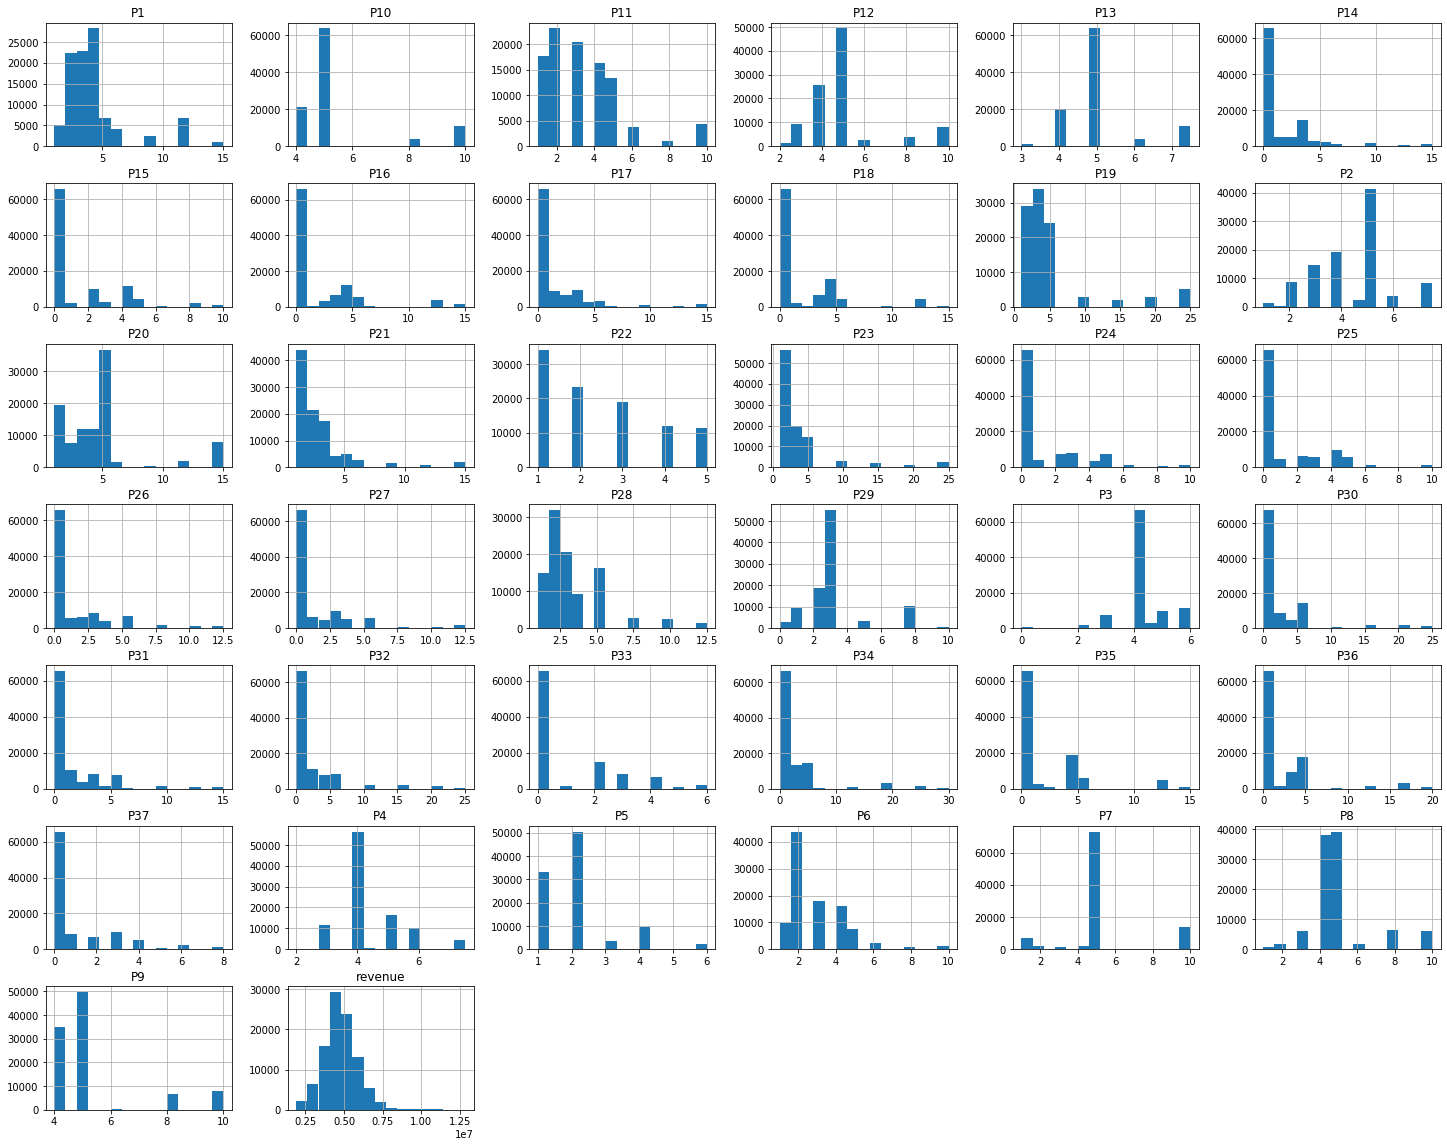

In [39]:


hist = train[train.columns[train.columns!='Id'] ].hist(bins=15,figsize=(25, 20))


In [5]:
counts = train['P25'].value_counts() 
percent = ((train['P25'].value_counts()/train['P25'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65493,65.7%
4,9419,9.4%
2,6209,6.2%
5,5590,5.6%
3,5525,5.5%
1,4426,4.4%
10,1577,1.6%
6,1170,1.2%
8,301,0.3%


In [6]:
counts = train['P26'].value_counts() 
percent = ((train['P26'].value_counts()/train['P26'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0.0,65540,65.7%
3.0,7505,7.5%
5.0,6415,6.4%
2.0,5958,6.0%
1.0,5319,5.3%
4.0,4081,4.1%
7.5,1782,1.8%
10.0,1249,1.3%
2.5,947,0.9%
12.5,914,0.9%


In [7]:
counts = train['P27'].value_counts() 
percent = ((train['P27'].value_counts()/train['P27'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0.0,65947,66.1%
1.0,6419,6.4%
3.0,6324,6.3%
5.0,5547,5.6%
4.0,5295,5.3%
2.0,4732,4.7%
2.5,3325,3.3%
12.5,1506,1.5%
7.5,311,0.3%
10.0,304,0.3%


In [37]:
counts = train['P28'].value_counts() 
percent = ((train['P28'].value_counts()/train['P28'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
2.0,29453,29.5%
3.0,20538,20.6%
5.0,16312,16.4%
1.0,15024,15.1%
4.0,9287,9.3%
7.5,2823,2.8%
10.0,2534,2.5%
2.5,2470,2.5%
12.5,1269,1.3%


In [36]:
counts = train['P29'].value_counts() 
percent = ((train['P29'].value_counts()/train['P29'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
3.0,55021,55.2%
2.0,17318,17.4%
7.5,10273,10.3%
1.0,9485,9.5%
5.0,3108,3.1%
0.0,2920,2.9%
2.5,1283,1.3%
10.0,302,0.3%


In [35]:
counts = train['P30'].value_counts() 
percent = ((train['P30'].value_counts()/train['P30'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65354,65.5%
5,14074,14.1%
3,6895,6.9%
4,4381,4.4%
1,2178,2.2%
20,1912,1.9%
15,1857,1.9%
2,1584,1.6%
25,889,0.9%
10,586,0.6%


In [31]:
counts = train['P31'].value_counts() 
percent = ((train['P31'].value_counts()/train['P31'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65324,65.5%
1,10061,10.1%
3,8121,8.1%
5,7817,7.8%
2,3663,3.7%
4,1609,1.6%
9,1281,1.3%
12,628,0.6%
15,621,0.6%
6,585,0.6%


In [30]:
counts = train['P32'].value_counts() 
percent = ((train['P32'].value_counts()/train['P32'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65542,65.7%
5,8301,8.3%
4,7859,7.9%
3,7453,7.5%
2,3791,3.8%
15,2179,2.2%
10,1800,1.8%
20,1218,1.2%
1,961,1.0%
25,606,0.6%


In [28]:
counts = train['P33'].value_counts() 
percent = ((train['P33'].value_counts()/train['P33'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
'''4.0''',66445,66.6%
'''6.0''',11275,11.3%
'''5.0''',9824,9.9%
'''3.0''',7168,7.2%
'''4.5''',2776,2.8%
'''2.0''',1904,1.9%
'''0.0''',318,0.3%


In [29]:
counts = train['P34'].value_counts() 
percent = ((train['P34'].value_counts()/train['P34'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65590,65.8%
3,10850,10.9%
4,10611,10.6%
5,3916,3.9%
18,3097,3.1%
2,2250,2.3%
24,1531,1.5%
1,648,0.6%
12,610,0.6%
30,306,0.3%


In [16]:
counts = train['P35'].value_counts() 
percent = ((train['P35'].value_counts()/train['P35'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65545,65.7%
4,18816,18.9%
5,6142,6.2%
12,4870,4.9%
1,2483,2.5%
15,949,1.0%
2,905,0.9%


In [34]:
counts = train['P36'].value_counts() 
percent = ((train['P36'].value_counts()/train['P36'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65417,65.6%
4,10897,10.9%
3,9149,9.2%
5,6840,6.9%
16,3045,3.1%
12,1535,1.5%
2,1270,1.3%
20,952,1.0%
1,313,0.3%
8,292,0.3%


In [19]:
counts = train['P37'].value_counts() 
percent = ((train['P37'].value_counts()/train['P37'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
0,65785,66.0%
3,9393,9.4%
1,8356,8.4%
2,6939,7.0%
4,5050,5.1%
6,2123,2.1%
8,1184,1.2%
5,880,0.9%


In [5]:
counts = train['P1'].value_counts() 
percent = ((train['P1'].value_counts()/train['P1'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
4,28254,28.3%
3,22809,22.9%
2,22438,22.5%
5,6854,6.9%
12,6848,6.9%
1,5031,5.0%
6,4091,4.1%
9,2488,2.5%
15,897,0.9%


In [6]:
counts = train['P2'].value_counts() 
percent = ((train['P2'].value_counts()/train['P2'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
5.0,41202,41.3%
4.0,19301,19.4%
3.0,14752,14.8%
2.0,8553,8.6%
7.5,8447,8.5%
6.0,3685,3.7%
4.5,2270,2.3%
1.0,1182,1.2%
1.5,318,0.3%


In [7]:
counts = train['P3'].value_counts() 
percent = ((train['P3'].value_counts()/train['P3'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
4.0,66445,66.6%
6.0,11275,11.3%
5.0,9824,9.9%
3.0,7168,7.2%
4.5,2776,2.8%
2.0,1904,1.9%
0.0,318,0.3%


In [8]:
counts = train['P4'].value_counts() 
percent = ((train['P4'].value_counts()/train['P4'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
4.0,56423,56.6%
5.0,16438,16.5%
3.0,11595,11.6%
6.0,9983,10.0%
7.5,4355,4.4%
4.5,606,0.6%
2.0,310,0.3%


In [9]:
counts = train['P5'].value_counts() 
percent = ((train['P5'].value_counts()/train['P5'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
2,50560,50.7%
1,33383,33.5%
4,9553,9.6%
3,3717,3.7%
6,2210,2.2%
5,287,0.3%


In [10]:
counts = train['P6'].value_counts() 
percent = ((train['P6'].value_counts()/train['P6'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
2,43860,44.0%
3,18055,18.1%
4,15930,16.0%
1,9838,9.9%
5,7390,7.4%
6,2469,2.5%
10,1247,1.3%
8,921,0.9%


In [11]:
counts = train['P7'].value_counts() 
percent = ((train['P7'].value_counts()/train['P7'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
5,73084,73.3%
10,13784,13.8%
1,6877,6.9%
2,2219,2.2%
4,1882,1.9%
3,1572,1.6%
6,292,0.3%


In [12]:
counts = train['P8'].value_counts() 
percent = ((train['P8'].value_counts()/train['P8'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
5,39176,39.3%
4,38107,38.2%
8,6553,6.6%
3,6170,6.2%
10,5916,5.9%
6,1586,1.6%
2,1564,1.6%
1,638,0.6%


In [13]:
counts = train['P9'].value_counts() 
percent = ((train['P9'].value_counts()/train['P9'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
5,49707,49.9%
4,35102,35.2%
10,8075,8.1%
8,6522,6.5%
6,304,0.3%


In [14]:
counts = train['P10'].value_counts() 
percent = ((train['P10'].value_counts()/train['P10'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
5,63570,63.8%
4,21125,21.2%
10,10968,11.0%
8,4047,4.1%


In [15]:
counts = train['P11'].value_counts() 
percent = ((train['P11'].value_counts()/train['P11'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
2,23055,23.1%
3,20399,20.5%
1,17585,17.6%
4,16214,16.3%
5,13412,13.5%
10,4402,4.4%
6,3686,3.7%
8,957,1.0%


In [163]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [ ]:
#imp_train = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=1)
#imp_test = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=2)


In [94]:
#p_data = ['P'+str(i) for i in range(1,38)]
#train[p_data] = np.round(imp_train.fit_transform(train[p_data]))


In [89]:
#p_data = ['P'+str(i) for i in range(1,38)]
#train_p = train[p_data]
#train_p = train_p.replace(0, np.nan)
#train[p_data] = train_p

In [165]:
print(train)

          Id   Open Date            City  City Group Type  P1   P2   P3   P4  \
0          0  01/22/2011           Niğde       Other   FC   1  4.0  4.0  4.0   
1          1  03/18/2011           Konya       Other   IL   3  4.0  4.0  4.0   
2          2  10/30/2013          Ankara  Big Cities   FC   3  4.0  4.0  4.0   
3          3  05/06/2013         Kocaeli       Other   IL   2  4.0  4.0  4.0   
4          4  07/31/2013  Afyonkarahisar       Other   FC   2  4.0  4.0  4.0   
...      ...         ...             ...         ...  ...  ..  ...  ...  ...   
99705  99995  01/05/2000         Antalya       Other   FC   5  5.0  4.0  4.0   
99706  99996  07/18/2011           Niğde       Other   IL   1  2.0  4.0  3.0   
99707  99997  12/29/2012        İstanbul  Big Cities   IL   4  5.0  4.0  4.0   
99708  99998  10/12/2013        İstanbul  Big Cities   FC  12  7.5  6.0  6.0   
99709  99999  10/05/2010        İstanbul  Big Cities   IL   2  5.0  4.0  4.0   

       P5  ...  P29  P30  P31  P32  P33

In [164]:
train.isnull().sum(axis = 0)


Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [109]:
(train['P37'] == 0).sum()


0

In [169]:
train['P5'] = train['P5'].apply(lambda x: "'" + str(x) + "'")


In [170]:
train['P22'] = train['P22'].apply(lambda x: "'" + str(x) + "'")


In [171]:
train['P33'] = train['P33'].apply(lambda x: "'" + str(x) + "'")


In [172]:
print(train)

          Id   Open Date            City  City Group Type  P1   P2   P3   P4  \
0          0  01/22/2011           Niğde       Other   FC   1  4.0  4.0  4.0   
1          1  03/18/2011           Konya       Other   IL   3  4.0  4.0  4.0   
2          2  10/30/2013          Ankara  Big Cities   FC   3  4.0  4.0  4.0   
3          3  05/06/2013         Kocaeli       Other   IL   2  4.0  4.0  4.0   
4          4  07/31/2013  Afyonkarahisar       Other   FC   2  4.0  4.0  4.0   
...      ...         ...             ...         ...  ...  ..  ...  ...  ...   
99705  99995  01/05/2000         Antalya       Other   FC   5  5.0  4.0  4.0   
99706  99996  07/18/2011           Niğde       Other   IL   1  2.0  4.0  3.0   
99707  99997  12/29/2012        İstanbul  Big Cities   IL   4  5.0  4.0  4.0   
99708  99998  10/12/2013        İstanbul  Big Cities   FC  12  7.5  6.0  6.0   
99709  99999  10/05/2010        İstanbul  Big Cities   IL   2  5.0  4.0  4.0   

          P5  ...  P29  P30  P31  P32  

In [176]:
dummy_train = pd.DataFrame()

In [177]:
dummy_train['P5'] = train['P5']

In [178]:
dummy_train['P22'] = train['P22']

In [179]:
dummy_train['P33'] = train['P33']

In [180]:
dummy_train['City Group'] = train['City Group']

In [181]:
dummy_train['Type'] = train['Type']

In [183]:
train_w_dummies = pd.get_dummies(data=dummy_train, drop_first=True)


In [194]:
train2 = train

In [195]:
print(train2)

          Id   Open Date            City  P1   P2   P3   P4  P6  P7  P8  ...  \
0          0  01/22/2011           Niğde   1  4.0  4.0  4.0   2   5   4  ...   
1          1  03/18/2011           Konya   3  4.0  4.0  4.0   2   5   3  ...   
2          2  10/30/2013          Ankara   3  4.0  4.0  4.0   2   5   4  ...   
3          3  05/06/2013         Kocaeli   2  4.0  4.0  4.0   3   5   4  ...   
4          4  07/31/2013  Afyonkarahisar   2  4.0  4.0  4.0   2   5   4  ...   
...      ...         ...             ...  ..  ...  ...  ...  ..  ..  ..  ...   
99705  99995  01/05/2000         Antalya   5  5.0  4.0  4.0   2   5   5  ...   
99706  99996  07/18/2011           Niğde   1  2.0  4.0  3.0   1   1   5  ...   
99707  99997  12/29/2012        İstanbul   4  5.0  4.0  4.0   2   5   3  ...   
99708  99998  10/12/2013        İstanbul  12  7.5  6.0  6.0   4  10  10  ...   
99709  99999  10/05/2010        İstanbul   2  5.0  4.0  4.0   2   5   5  ...   

       P28  P29  P30  P31  P32  P34  P3

In [196]:
frames = [train2, train_w_dummies]


In [199]:
print(train2)

          Id   Open Date            City  P1   P2   P3   P4  P6  P7  P8  ...  \
0          0  01/22/2011           Niğde   1  4.0  4.0  4.0   2   5   4  ...   
1          1  03/18/2011           Konya   3  4.0  4.0  4.0   2   5   3  ...   
2          2  10/30/2013          Ankara   3  4.0  4.0  4.0   2   5   4  ...   
3          3  05/06/2013         Kocaeli   2  4.0  4.0  4.0   3   5   4  ...   
4          4  07/31/2013  Afyonkarahisar   2  4.0  4.0  4.0   2   5   4  ...   
...      ...         ...             ...  ..  ...  ...  ...  ..  ..  ..  ...   
99705  99995  01/05/2000         Antalya   5  5.0  4.0  4.0   2   5   5  ...   
99706  99996  07/18/2011           Niğde   1  2.0  4.0  3.0   1   1   5  ...   
99707  99997  12/29/2012        İstanbul   4  5.0  4.0  4.0   2   5   3  ...   
99708  99998  10/12/2013        İstanbul  12  7.5  6.0  6.0   4  10  10  ...   
99709  99999  10/05/2010        İstanbul   2  5.0  4.0  4.0   2   5   5  ...   

       P28  P29  P30  P31  P32  P34  P3

In [200]:
combined_train = pd.concat(frames,axis=1)


In [225]:
combined_train['revenue'] = train2['revenue']

In [149]:
counts = train['P5'].value_counts() 
percent = ((train['P5'].value_counts()/train['P5'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
'2',50560,50.7%
'1',33383,33.5%
'4',9553,9.6%
'3',3717,3.7%
'6',2210,2.2%
'5',287,0.3%


In [150]:
counts = train['P22'].value_counts() 
percent = ((train['P22'].value_counts()/train['P22'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
'1',34139,34.2%
'2',23363,23.4%
'3',18834,18.9%
'4',11859,11.9%
'5',11515,11.5%


In [151]:
counts = train['P33'].value_counts() 
percent = ((train['P33'].value_counts()/train['P33'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(20)

,count,percentage
'0',65548,65.7%
'2',14938,15.0%
'3',8386,8.4%
'4',6418,6.4%
'6',1876,1.9%
'1',1520,1.5%
'5',1024,1.0%


0        4.244606e+06
1        3.287352e+06
2        4.219404e+06
3        3.937159e+06
4        5.877729e+06
             ...     
99705    4.575160e+06
99706    2.513131e+06
99707    4.410235e+06
99708    4.473647e+06
99709    5.625029e+06
Name: revenue, Length: 99710, dtype: float64

In [152]:
import dask.dataframe as dd


In [228]:
combined_train.to_csv('s3://aifa-team-purple/dataset/cleaned-dataset-2021-09-26/train.csv', index=False)

In [235]:
test = pd.read_csv('Ashwin-EDA/test_data.csv')


KeyError: 'REVENUE'

In [204]:
test['P5'] = test['P5'].apply(lambda x: "'" + str(x) + "'")


In [205]:
test['P22'] = test['P22'].apply(lambda x: "'" + str(x) + "'")


In [206]:
test['P33'] = test['P33'].apply(lambda x: "'" + str(x) + "'")


In [207]:
dummy_test = pd.DataFrame()

In [208]:
dummy_test['P5'] = test['P5']

In [210]:
dummy_test['P22'] = test['P22']

In [211]:
dummy_test['P33'] = test['P33']

In [212]:
dummy_test['City Group'] = test['City Group']

In [213]:
dummy_test['Type'] = test['Type']

In [214]:
test_w_dummies = pd.get_dummies(data=dummy_test, drop_first=True)


In [215]:
test.drop(['P5', 'P22','P33','City Group', 'Type'], axis=1, inplace=True)


In [218]:
test2 = test

In [233]:
test['revenue']

KeyError: 'revenue'

In [220]:
frames = [test2, test_w_dummies]


In [221]:
combined_test = pd.concat(frames,axis=1)


In [239]:
combined_test

,Id,Open Date,City,P1,P2,P3,P4,P6,P7,P8,...,P22_'4',P22_'5',P33_'2',P33_'3',P33_'4',P33_'5',P33_'6',City Group_Other,Type_FC,Type_IL
0,0,7/17/99,İstanbul,4,5.0,4.0,4.0,2,5,4,...,0,0,0,0,0,1,0,0,0,1
1,1,2/14/08,Ankara,4,5.0,4.0,4.0,2,5,5,...,0,0,0,0,0,0,0,0,1,0
2,2,3/9/13,Diyarbakır,2,4.0,2.0,5.0,3,5,5,...,0,0,0,0,0,0,0,1,0,1
3,3,2/2/12,Tokat,6,4.5,6.0,6.0,4,10,8,...,0,0,0,0,0,0,1,1,0,1
4,4,5/9/09,Gaziantep,3,4.0,3.0,4.0,2,5,5,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,6/25/08,Trabzon,2,3.0,3.0,5.0,2,4,4,...,0,0,0,0,0,0,0,1,1,0
133,133,10/12/06,İzmir,4,5.0,4.0,4.0,3,5,4,...,0,0,0,0,0,0,0,0,1,0
134,134,7/8/06,Kayseri,3,4.0,4.0,4.0,3,5,5,...,0,0,0,0,0,0,0,1,1,0
135,135,10/29/10,İstanbul,4,5.0,4.0,5.0,2,5,5,...,0,0,0,0,0,0,0,0,1,0


In [240]:
combined_test.to_csv('s3://aifa-team-purple/dataset/cleaned-dataset-2021-09-26/test.csv', index=False)